# SISTEMA DE INFORMAÇÃO DE ATENÇÃO BÁSICA - CADASTRAMENTO FAMILIAR
## Anos : 2003 até 2015
### Fonte: DATASUS (http://www2.datasus.gov.br)

# Dados utilizados
#### Atenção Básica - Saúde da Família - Cadastramento Famíliar - 2003 até 2015
#### População Residente por Unidade da Federação segundo Município - 2003 até 2015
#### Renda média domic. per capita segundo Município - Censo 2010
#### Shapefile com os municípios do estado de São Paulo

# Programas utilizados
#### Python ( Linguagem de programação)
#### Jupyter notebook (aplicação para desenvolvimento)
#### Pandas(Biblioteca python para análise de dados)
#### Geopandas(Biblioteca python para análise de dados geográficos)


# Metodologia 
### Importação dos arquivos contendo os dados para o Python
### Criação do arquivo com a união dos dados tabulares e geográficos
### Criação dos índices:
#### - Famílias atendidas/População em 2014
#### - Famílias atendidas/População em 2003 - Famílias atendidas/População em 2014
#### - Índice de crescimento sobre famílias atendidas pela saúde da família entre 2003 e 2014 (2014 - 2003)
#### - Índice de Crescimento Populacional Entre 2003 e 2014 (2014 - 2003)

In [104]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from geopandas import GeoDataFrame

In [105]:
# Adicionando o arquivo CSV relacionado a renda média domiciliar do ano de 2010 e arrumando as colunas do dataframe

colunas = ('nome renda2010').split()

renda2010 = pd.read_csv('./Renda/2010.csv', sep=';', encoding='ANSI', engine='python')
renda2010.columns = colunas

listaMunicipio = []

for item in renda2010['nome']:
    listaMunicipio.append(item[7:])
    
renda2010['nome'] = listaMunicipio    

renda2010.nome = renda2010.nome.str.upper()
#renda2010.sort_values(by='renda2010', ascending = False)

In [106]:
# Adicionando o arquivo CSV relacionado ao número de famílias atendidas pela saúde da família do ano 
# de 2010 e arrumando as colunas do dataframe

colunas = ('nome familias2003').split()
df2003 = pd.read_csv('./Familia/2003.csv', sep=';', encoding='ANSI')
df2003.columns = colunas

listaMunicipio = []

for item in df2003['nome']:
    listaMunicipio.append(item[7:])
    
df2003['nome'] = listaMunicipio   

df2003.nome = df2003.nome.str.upper()

In [107]:
# Adicionando o arquivo CSV relacionado ao número de famílias atendidas pela saúde da família do ano 
# de 2014 e arrumando as colunas do dataframe

colunas = ('nome familias2014').split()
df2014 = pd.read_csv('./Familia/2014.csv', sep=';', encoding='ANSI')
df2014.columns = colunas

listaMunicipio = []

for item in df2014['nome']:
    listaMunicipio.append(item[7:])
    
df2014['nome'] = listaMunicipio 

df2014.nome = df2014.nome.str.upper()

In [108]:
# Adicionando o arquivo CSV relacionado a população do ano de 2003 e arrumando as colunas do dataframe

colunas = ('nome populacao2003 apagar').split()

populacao2003 = pd.read_csv('./População/2003.csv', sep=';', encoding='ANSI', engine='python')
populacao2003.columns = colunas

listaMunicipio = []

for item in populacao2003['nome']:
    listaMunicipio.append(item[7:])
    
populacao2003['nome'] = listaMunicipio    

populacao2003.nome = populacao2003.nome.str.upper()
populacao2003 = populacao2003.drop('apagar',1)

In [109]:
# Adicionando o arquivo CSV relacionado a população do ano de 2014 e arrumando as colunas do dataframe

colunas = ('nome populacao2014').split()
populacao2014 = pd.read_csv('./População/2014.csv', sep=';', encoding='ANSI', engine='python')
populacao2014.columns = colunas

listaMunicipio = []

for item in populacao2014['nome']:
    listaMunicipio.append(item[7:])
    
populacao2014['nome'] = listaMunicipio    

populacao2014.nome = populacao2014.nome.str.upper()


In [110]:
# Adicionando o shapefile dos municípios do estado de São Paulo

shp = gpd.read_file('./Shapefile/municipios.shp')
colunas = ('nome','geocod','geometry')
shp.columns = colunas
shp = shp.set_index('geocod')

In [111]:
# Inserindo os dados tabulares no shapefile, para construir a base de dados necessária para a análise

merged = df2014.merge(shp,left_on='nome',right_on='nome',how='left')
merged = df2003.merge(merged,left_on='nome',right_on='nome',how='left')
merged = populacao2014.merge(merged,left_on='nome',right_on='nome',how='left')
merged = populacao2003.merge(merged,left_on='nome',right_on='nome',how='left')
merged = renda2010.merge(merged,left_on='nome',right_on='nome',how='left')

merged = merged.dropna(subset=['populacao2003', 'populacao2014','geometry','familias2003','familias2014'])
merged = GeoDataFrame(merged, crs=4674, geometry='geometry') ## transformando em geodataframe

In [112]:
#Calculando os índices e adicionando no shapefile (colunas: fam2014_2003, pop2014_2003,indice,indfam2014)

merged['fam2014_2003'] = ((merged['familias2014']-merged['familias2003'])/merged['familias2003']) + 1
merged['pop2014_2003'] = ((merged['populacao2014']-merged['populacao2003'])/merged['populacao2003']) + 1
merged['indice'] = (merged['familias2003']/merged['populacao2003']) - (merged['familias2014']/merged['populacao2014'])
merged['indfam2014'] = (merged['familias2014']/merged['populacao2014'])

In [113]:
#Criando classes relacionadas a coluna renda2010 e adicionando na coluna classe
# Classes:
# Menor que 510
# Maior ou igual a 510 e menor que 1020
# Maior ou igual 1020

classe = []
for valor in merged['renda2010']:
    if valor < 510:
        classe.append('Baixa')
    elif valor < 1020:
        classe.append('Média')
    else:
        classe.append('Alta')
        
merged['classe'] = classe

Text(0.5, 1.0, 'Renda Média Domiciliar per Capita - Censo 2010')

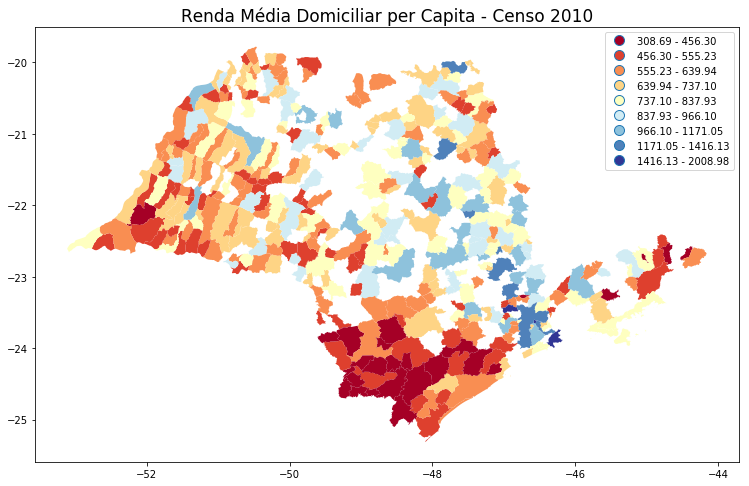

In [114]:
merged.plot(column = 'renda2010', figsize=(18,8),cmap='RdYlBu', scheme='fisher_jenks', k=9, legend=True)
plt.title('Renda Média Domiciliar per Capita - Censo 2010', fontsize = 17)

Text(0.5, 1.0, 'Divisão de Classes por Renda - Censo 2010')

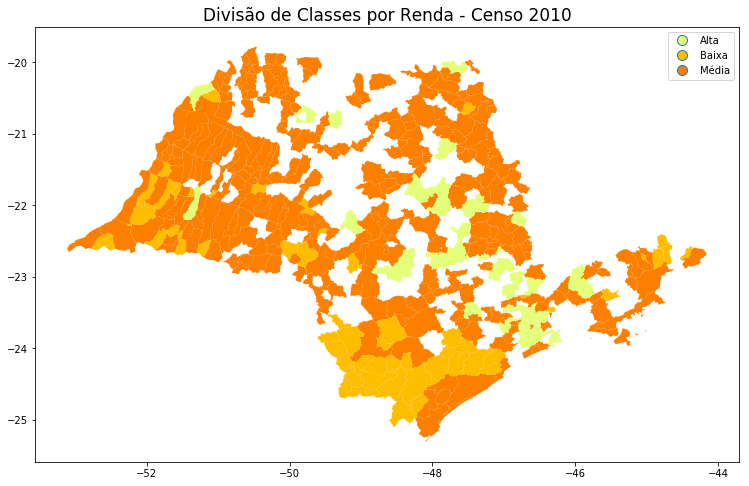

In [115]:
merged.plot(column = 'classe', figsize=(18,8),cmap='Wistia', legend=True)
plt.title('Divisão de Classes por Renda - Censo 2010', fontsize = 17)

Text(0.5, 1.0, 'Famílias atendidas/População em 2014')

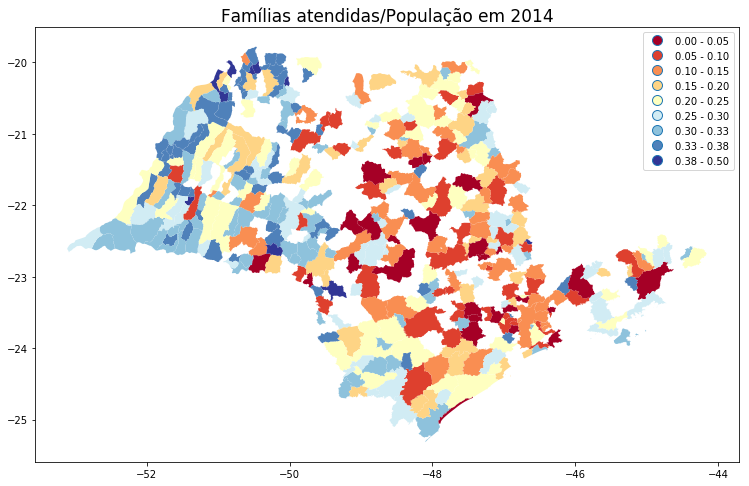

In [116]:
merged.plot(column = 'indfam2014', figsize=(18,8),cmap='RdYlBu', scheme='fisher_jenks', k=9, legend=True)
plt.title('Famílias atendidas/População em 2014', fontsize = 17)

Text(0.5, 1.0, 'Famílias atendidas/População em 2003 - Famílias atendidas/População em 2014')

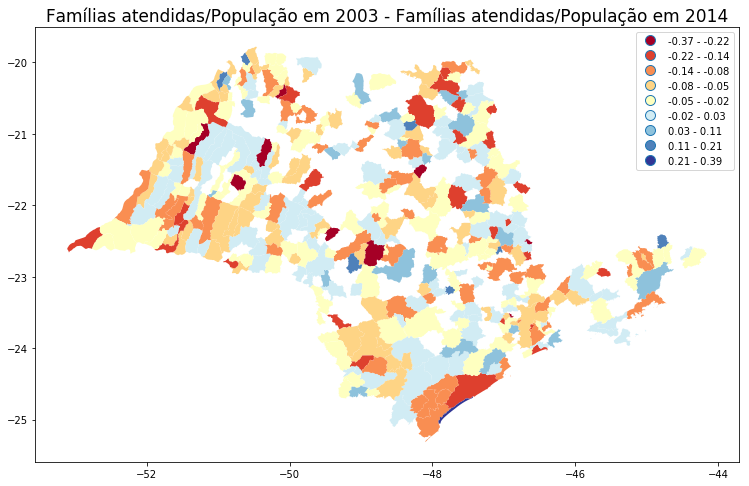

In [117]:
merged.plot(column = 'indice', figsize=(18,8),cmap='RdYlBu', scheme='fisher_jenks', k=9, legend=True)
plt.title('Famílias atendidas/População em 2003 - Famílias atendidas/População em 2014', fontsize = 17)

Text(0.5, 1.0, 'Índice de crescimento sobre famílias atendidas pela saúde da família entre 2003 e 2014')

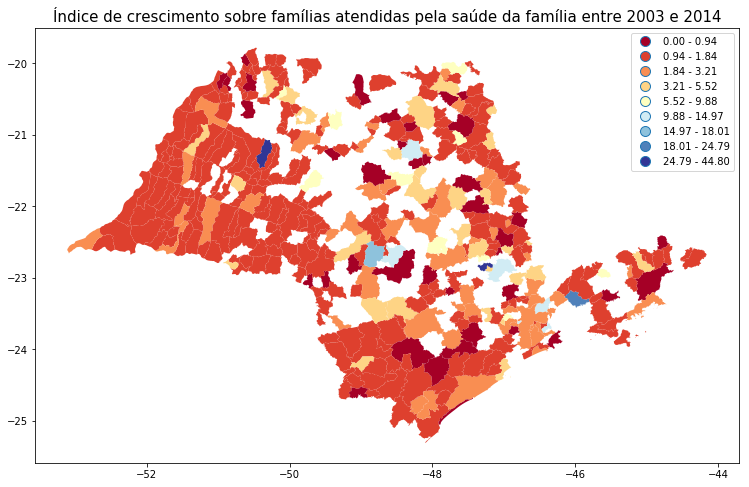

In [118]:
merged.plot(column = 'fam2014_2003', figsize=(18,8),cmap='RdYlBu', scheme='fisher_jenks', k=9, legend=True)
plt.title('Índice de crescimento sobre famílias atendidas pela saúde da família entre 2003 e 2014', fontsize = 15)

Text(0.5, 1.0, 'Índice de Crescimento Populacional Entre 2003 e 2014 ')

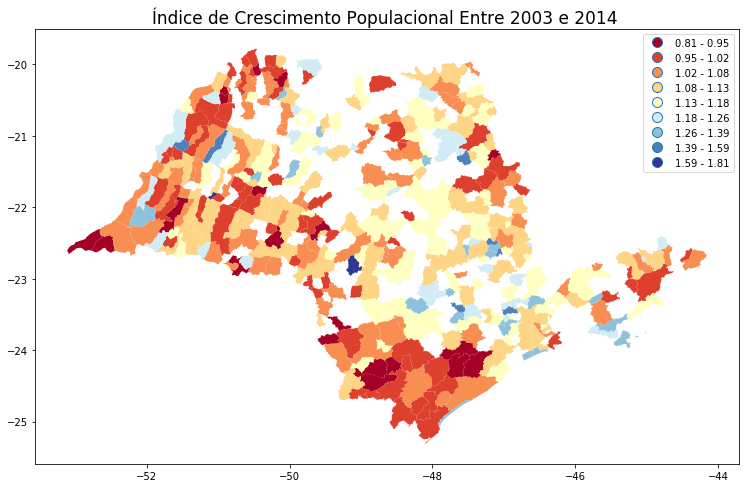

In [119]:
merged.plot(column = 'pop2014_2003', figsize=(18,8),cmap='RdYlBu', scheme='fisher_jenks', k=9, legend=True)
plt.title('Índice de Crescimento Populacional Entre 2003 e 2014 ', fontsize = 17)